In [1]:
# Import necessary libraries

from IPython.core import prefilter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import warnings

import matplotlib.colors
pal = ['#009473', '#00537c', '#b4b4b4', '#da3e21']
cmap = matplotlib.colors.ListedColormap(pal)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Ignore specific warning categories

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Read the CSV file into a Pandas DataFrame

dot = pd.read_csv(r'/kaggle/input/factors-affecting-children-anemia-level/children anemia.csv')

In [4]:
# Set Pandas display options to show a maximum of 100 rows and columns, and set the display width to 100 characters

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

In [5]:
# Display the first few rows of the DataFrame

dot.head()

,Age in 5-year groups,Type of place of residence,Highest educational level,Wealth index combined,Births in last five years,Age of respondent at 1st birth,Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal),Anemia level,Have mosquito bed net for sleeping (from household questionnaire),Smokes cigarettes,Current marital status,Currently residing with husband/partner,When child put to breast,Had fever in last two weeks,Hemoglobin level adjusted for altitude (g/dl - 1 decimal),Anemia level.1,"Taking iron pills, sprinkles or syrup"
0,40-44,Urban,Higher,Richest,1,22,NaN,NaN,Yes,No,Living with partner,Staying elsewhere,Immediately,No,NaN,NaN,Yes
1,35-39,Urban,Higher,Richest,1,28,NaN,NaN,Yes,No,Married,Living with her,Hours: 1,No,NaN,NaN,No
2,25-29,Urban,Higher,Richest,1,26,NaN,NaN,No,No,Married,Living with her,Immediately,No,NaN,NaN,No
3,25-29,Urban,Secondary,Richest,1,25,95.0,Moderate,Yes,No,Married,Living with her,105.0,No,114.0,Not anemic,No
4,20-24,Urban,Secondary,Richest,1,21,NaN,NaN,Yes,No,No longer living together/separated,NaN,Immediately,No,NaN,NaN,No


In [6]:
# Get the shape of the DataFrame (number of rows and columns)

dot.shape

(33924, 17)

In [7]:
# Check and count the number of missing values in each column of the DataFrame

dot.isnull().sum()

Age in 5-year groups                                                         0
Type of place of residence                                                   0
Highest educational level                                                    0
Wealth index combined                                                        0
Births in last five years                                                    0
Age of respondent at 1st birth                                               0
Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)    20788
Anemia level                                                             20788
Have mosquito bed net for sleeping (from household questionnaire)            0
Smokes cigarettes                                                            0
Current marital status                                                       0
Currently residing with husband/partner                                   1698
When child put to breast                            

In [8]:
# Get the names of the columns

dot.columns

Index(['Age in 5-year groups', 'Type of place of residence', 'Highest educational level',
       'Wealth index combined', 'Births in last five years', 'Age of respondent at 1st birth',
       'Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)', 'Anemia level',
       'Have mosquito bed net for sleeping (from household questionnaire)', 'Smokes cigarettes',
       'Current marital status', 'Currently residing with husband/partner',
       'When child put to breast', 'Had fever in last two weeks',
       'Hemoglobin level adjusted for altitude (g/dl - 1 decimal)', 'Anemia level.1',
       'Taking iron pills, sprinkles or syrup'],
      dtype='object')

In [9]:
# Rename columns for better clarity and ease of analysis

dot.rename(columns={'Age in 5-year groups': 'age',
                   'Type of place of residence': 'residence',
                   'Highest educational level': 'highest_educational',
                   'Wealth index combined': 'wealth_index',
                   'Births in last five years': 'births_5_years',
                   'Age of respondent at 1st birth': 'respondent_1st_birth',
                   'Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)': 'hemoglobin_altitude_smoking',
                   'Anemia level': 'anemia_level_target',
                   'Have mosquito bed net for sleeping (from household questionnaire)': 'mosquito_bed_sleeping',
                   'Smokes cigarettes': 'smoking',
                   'Current marital status': 'status',
                   'Currently residing with husband/partner': 'residing_husband_partner',
                   'When child put to breast': 'child_put_breast',
                   'Had fever in last two weeks': 'fever_two_weeks',
                   'Hemoglobin level adjusted for altitude (g/dl - 1 decimal)': 'hemoglobin_altitude',
                   'Anemia level.1': 'anemia_level_1',
                   'Taking iron pills, sprinkles or syrup': 'iron_pills'}, inplace=True)


In [10]:
# Function to replace NaN values with the mean of the column
def reloc_nan(x):
    """
    Replace NaN values in a pandas Series with the mean of the column.

    """
    mean_value = x.mean()  # Calculate the mean value of the column
    return x.fillna(mean_value)  # Replace NaN values with the mean


In [11]:
# Replace NaN values in the 'hemoglobin_altitude_smoking' column with the mean of the column

dot['hemoglobin_altitude_smoking'] = reloc_nan(dot['hemoglobin_altitude_smoking'])

In [12]:
# Define a function to replace NaN values in the 'residing_husband_partner' column with a specific word

def replace_nan_residing(x):
    """
    Replace NaN values in a pandas Series with a specific word.

    """
    word = 'Staying elsewhere'  # Specify the word to replace NaN values
    return x.fillna(word)  # Replace NaN values with the specified word

# Apply the function to replace NaN values in the 'residing_husband_partner' column
dot['residing_husband_partner'] = replace_nan_residing(dot['residing_husband_partner'])


In [13]:
# Convert categorical values in 'child_put_breast' column to numerical representation

def func_child_put_breast(dot):

    values = dot['child_put_breast'].values
    for idx, val in enumerate(values):
        values[idx] = 0 if val == 'Immediately' else (0.5 if val == 'Hours: 1' else (1 if val == 'Days: 1' else val))
    dot['child_put_breast'] = values
    return dot

# Apply function to convert categorical values in 'child_put_breast' column
dot = func_child_put_breast(dot)


In [14]:
# Convert the 'child_put_breast' column to the float64 data type

dot['child_put_breast'] = dot['child_put_breast'].astype('float64')


In [15]:
# Replace NaN values in the 'child_put_breast' column with the mean of the column

dot['child_put_breast'] = reloc_nan(dot['child_put_breast'])


In [16]:
# Fill NaN values in the 'fever_two_weeks' column with the string "Dont know"

dot['fever_two_weeks'] = dot['fever_two_weeks'].fillna("Dont know")


In [17]:
# Replace NaN values in 'hemoglobin_altitude' column with the mean and round to 1 decimal place

dot['hemoglobin_altitude'] = reloc_nan(dot['hemoglobin_altitude']).apply(lambda x: round(x, 1))


In [18]:
# Fill NaN values in specified columns with the string "Dont know"

dot['anemia_level_1'] = dot['anemia_level_1'].fillna("Dont know")
dot['iron_pills'] = dot['iron_pills'].fillna("Dont know")
dot['anemia_level_target'] = dot['anemia_level_target'].fillna("Dont know")


In [19]:
# Define a function to replace specific values in the DataFrame with standardized values

def func_replace(dot):

    def val_replace(value):
        if value == "Don't know":
            return 'Dont know'
        else:
            return value

    # Apply the value replacement function to all elements in the DataFrame
    dot = dot.applymap(val_replace)
    return dot

# Apply the function to replace specific values in the DataFrame
dot = func_replace(dot)


In [20]:
# Generate and transpose descriptive statistics summary for the DataFrame

dot.describe().T


,count,mean,std,min,25%,50%,75%,max
births_5_years,33924.0,1.823783,0.705460,1.0,1.000000,2.000000,2.000000,6.0
respondent_1st_birth,33924.0,19.570776,4.313172,12.0,16.000000,19.000000,22.000000,48.0
hemoglobin_altitude_smoking,33924.0,114.367235,9.903431,20.0,114.367235,114.367235,114.367235,218.0
child_put_breast,33924.0,40.690429,48.417658,0.0,0.000000,40.690429,40.690429,223.0
hemoglobin_altitude,33924.0,101.291051,8.529540,29.0,101.300000,101.300000,101.300000,170.0


In [21]:
# Define a function to calculate the mean of age groups represented as strings

def func_mean_column_age(x):
  
    if isinstance(x, str):
        start, end = map(int, x.split('-'))
        return (start + end) / 2
    else:
        return x

# Apply the function to calculate the mean of age groups in the 'age' column
dot['age'] = dot['age'].apply(lambda x: func_mean_column_age(x) if isinstance(x, str) else x)


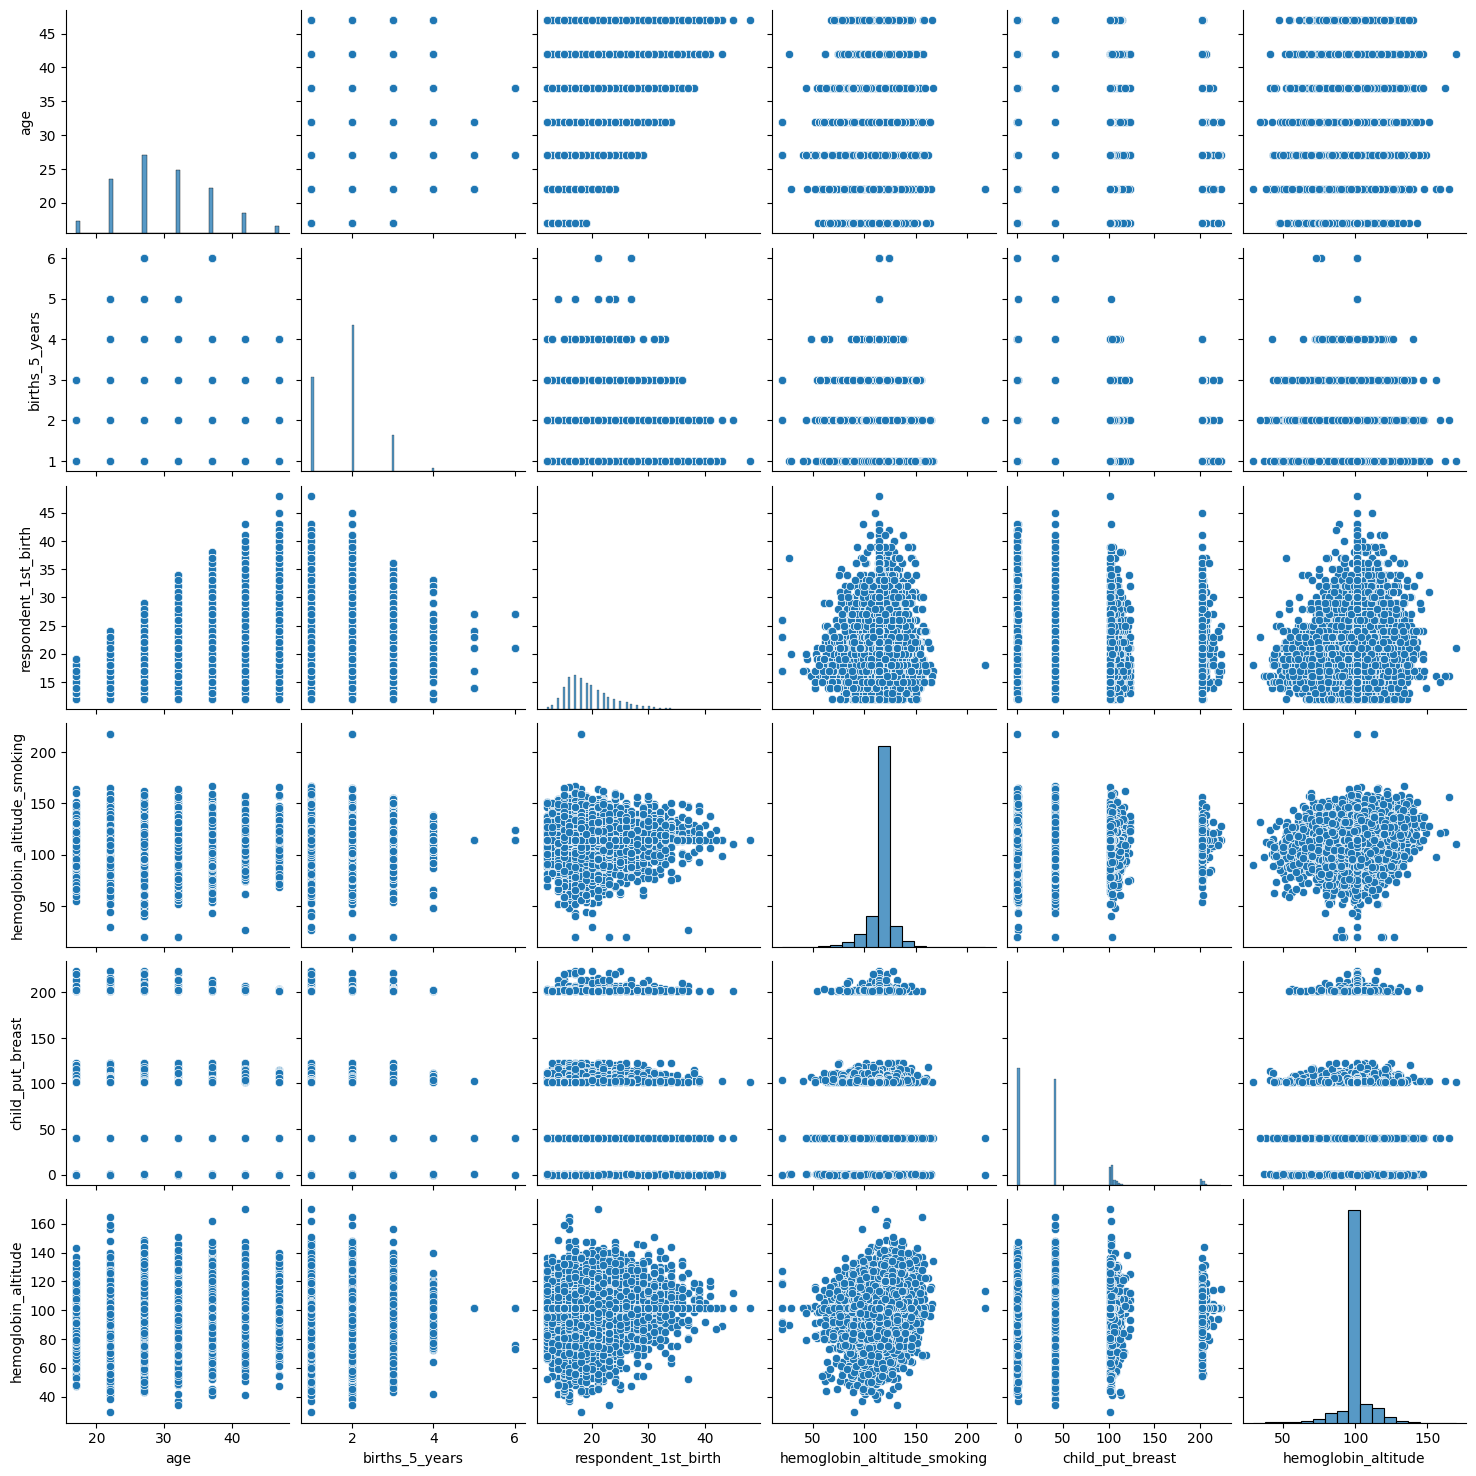

In [22]:
# Generate a pair plot for visualizing relationships between numerical variables

sns.pairplot(dot)


In [23]:

# Map 'Yes' to 1 and 'No' to 0 in specified columns

col = ['mosquito_bed_sleeping', 'smoking', 'fever_two_weeks', 'iron_pills']

for column in col:
    dot[column] = dot[column].map({'Yes': 1, 'No': 0})


In [24]:
# Display the unique values in the 'status' column

dot['status'].unique()


array(['Living with partner', 'Married',
       'No longer living together/separated', 'Never in union', 'Widowed',
       'Divorced'], dtype=object)

In [25]:
# Replace 'No longer living together/separated' with 'Separated' in the 'status' column

dot['status'] = dot['status'].replace('No longer living together/separated', 'Separated')


In [26]:

# Create dummy variables for specified categorical columns and concatenate them to the DataFrame

col = ['residence', 'highest_educational', 'wealth_index']

for column in col:
    # Generate dummy variables and drop the first category to avoid multicollinearity
    status = pd.get_dummies(dot[column], prefix=column, drop_first=False)
    
    # Concatenate dummy variables to the original DataFrame
    dot = pd.concat([dot, status], axis=1)



In [27]:
# Drop specified columns 'residence', 'highest_educational', 'wealth_index' from the DataFrame

dot = dot.drop(columns=['residence', 'highest_educational', 'wealth_index'], axis=1)


In [28]:
# Display the first few rows of the modified DataFrame

dot.head()


,age,births_5_years,respondent_1st_birth,hemoglobin_altitude_smoking,anemia_level_target,mosquito_bed_sleeping,smoking,status,residing_husband_partner,child_put_breast,fever_two_weeks,hemoglobin_altitude,anemia_level_1,iron_pills,residence_Rural,residence_Urban,highest_educational_Higher,highest_educational_No education,highest_educational_Primary,highest_educational_Secondary,wealth_index_Middle,wealth_index_Poorer,wealth_index_Poorest,wealth_index_Richer,wealth_index_Richest
0,42.0,1,22,114.367235,Dont know,1,0,Living with partner,Staying elsewhere,0.0,0.0,101.3,Dont know,1.0,False,True,True,False,False,False,False,False,False,False,True
1,37.0,1,28,114.367235,Dont know,1,0,Married,Living with her,0.5,0.0,101.3,Dont know,0.0,False,True,True,False,False,False,False,False,False,False,True
2,27.0,1,26,114.367235,Dont know,0,0,Married,Living with her,0.0,0.0,101.3,Dont know,0.0,False,True,True,False,False,False,False,False,False,False,True
3,27.0,1,25,95.000000,Moderate,1,0,Married,Living with her,105.0,0.0,114.0,Not anemic,0.0,False,True,False,False,False,True,False,False,False,False,True
4,22.0,1,21,114.367235,Dont know,1,0,Separated,Staying elsewhere,0.0,0.0,101.3,Dont know,0.0,False,True,False,False,False,True,False,False,False,False,True


In [29]:
# Drop rows with any missing values from the DataFrame

dot = dot.dropna()


In [30]:
# Copy DataSet
dot_df_copy = dot.copy()

In [31]:
# Separate features (X) and target variable (y) from the DataFrame

X = dot.drop(columns=['anemia_level_target'], axis=1)  # Features
y = dot['anemia_level_target']  # Target variable


In [32]:
# Identify columns with object (categorical) data in the features (X)

obj = [col for col in X.columns if dot[col].dtype == 'object']


In [33]:
# List of column names in X with 'object' data type (likely categorical variables)

print(obj)


['status', 'residing_husband_partner', 'anemia_level_1']


In [34]:
# Display the unique values in the target variable (y)

y.unique()


array(['Dont know', 'Moderate', 'Mild', 'Not anemic', 'Severe'],
      dtype=object)

In [35]:

# Apply Label Encoding to categorical columns in the features (X)

for i in obj:
    lr = LabelEncoder()  # Initialize a LabelEncoder for the current column
    X[i] = lr.fit_transform(X[i])  # Transform the categorical values to numerical labels




In [36]:
# Map categories in the target variable (y) to numerical labels

y = y.map({'Dont know': 0, 'Moderate': 1, 'Mild': 2, 'Not anemic': 3, 'Severe': 4})


In [37]:

# Split the dataset into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)


In [38]:

# Standardize the features using StandardScaler

std = StandardScaler()
X = std.fit_transform(X)


In [39]:

# Create a Logistic Regression model, fit it on the training data, and predict on the test data

lrg = LogisticRegression()
lrg.fit(X_train, y_train)
y_pred = lrg.predict(X_test)


In [40]:
# Calculate evaluation metrics for the Logistic Regression model

mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)    # Mean Squared Error
r2 = r2_score(y_test, y_pred)              # R-squared
msre = np.sqrt(mse)                         # Root Mean Squared Error


In [41]:
# Print the calculated evaluation metrics for the Logistic Regression model

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('R-squared:', r2)
print('Root Mean Squared Error:', msre)


Mean Absolute Error: 0.3964274008521796
Mean Squared Error: 0.8556211078334972
R-squared: 0.3777578930707103
Root Mean Squared Error: 0.9249978961238221


In [42]:

# Create a Decision Tree Classifier model, fit it on the training data, and predict on the test data

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)


In [43]:

# Print the classification report for the Decision Tree Classifier model

print('Decision Tree Classifier Classification Report:\n', classification_report(y_test, y_pred_dtc))


Decision Tree Classifier Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3783
           1       0.90      0.93      0.91       683
           2       0.85      0.82      0.84       641
           3       0.95      0.95      0.95       957
           4       0.88      0.95      0.91        38

    accuracy                           0.96      6102
   macro avg       0.92      0.93      0.92      6102
weighted avg       0.96      0.96      0.96      6102



In [44]:


# Create Random Forest, Extra Trees, and Gradient Boosting classifiers

rd = RandomForestClassifier()
ex = ExtraTreesClassifier()
gb = GradientBoostingClassifier()

# Fit the classifiers on the training data
rd.fit(X_train, y_train)
ex.fit(X_train, y_train)
gb.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rd = rd.predict(X_test)
y_pred_ex = ex.predict(X_test)
y_pred_gb = gb.predict(X_test)

# Print classification reports for each classifier
print('Random Forest Classifier:')
print(classification_report(y_test, y_pred_rd))
print('Extra Trees Classifier:')
print(classification_report(y_test, y_pred_ex))
print('Gradient Boosting Classifier:')
print(classification_report(y_test, y_pred_gb))





Random Forest Classifier:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3783
           1       0.86      1.00      0.92       683
           2       0.87      0.84      0.86       641
           3       1.00      0.94      0.97       957
           4       1.00      0.26      0.42        38

    accuracy                           0.97      6102
   macro avg       0.94      0.81      0.83      6102
weighted avg       0.97      0.97      0.96      6102

Extra Trees Classifier:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3783
           1       0.79      0.84      0.82       683
           2       0.71      0.54      0.61       641
           3       0.90      0.90      0.90       957
           4       1.00      0.37      0.54        38

    accuracy                           0.91      6102
   macro avg       0.87      0.73      0.77      6102
weighted avg       0.91    

In [45]:
# Create an XGBoost Regressor

xgb_regres = xgb.XGBRegressor()

# Define the hyperparameter grid for grid search
param_grid = {
    'n_estimators': [1000],
    'max_depth': [6],
    'learning_rate': [0.01],
}

# Perform grid search with cross-validation
gridcv = GridSearchCV(estimator=xgb_regres, param_grid=param_grid, cv=5)
gridcv.fit(X_train, y_train)

# Print the best hyperparameters from the grid search
print('The best parameters are:', gridcv.best_params_)

# Make predictions on the test data using the best model from grid search
y_pred_xgb_regres = gridcv.predict(X_test)
y_pred_xgb_regres_round = [round(pred) for pred in y_pred_xgb_regres]

# Print the classification report for XGBoost Regressor
print('XGBoost Regressor Classification Report:')
print(classification_report(y_test, y_pred_xgb_regres_round))




The best parameters are: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000}
XGBoost Regressor Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3783
           1       0.88      0.99      0.93       683
           2       0.89      0.85      0.87       641
           3       0.98      0.93      0.96       957
           4       0.97      0.79      0.87        38

    accuracy                           0.97      6102
   macro avg       0.94      0.91      0.93      6102
weighted avg       0.97      0.97      0.97      6102



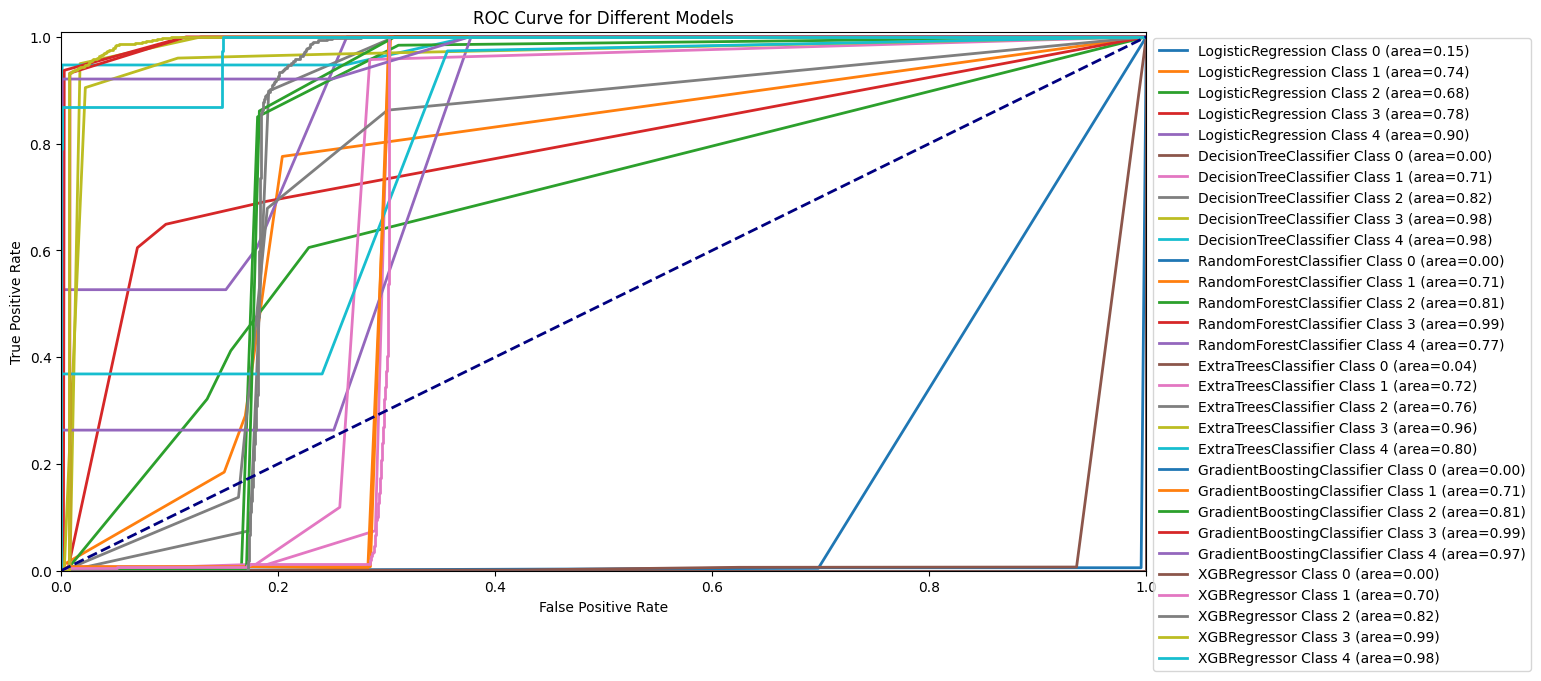

In [46]:
# List of models and their corresponding predicted values

models = [
    ('LogisticRegression', y_pred),
    ('DecisionTreeClassifier', y_pred_dtc),
    ('RandomForestClassifier', y_pred_rd),
    ('ExtraTreesClassifier', y_pred_ex),
    ('GradientBoostingClassifier', y_pred_gb),
    ('XGBRegressor', y_pred_xgb_regres)
]

# Create a figure for the ROC curve plot
plt.figure(figsize=(14, 7))

# Loop through each model and calculate ROC curve and AUC for each class
for model_name, y_pred_model in models:

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(np.unique(y_test))):
        y_true_bin = np.zeros_like(y_test)
        y_pred_bin = np.zeros_like(y_test)
        y_true_bin[y_test == i] = 1
        y_pred_bin = y_pred_model
        fpr[i], tpr[i], _ = roc_curve(y_true_bin, y_pred_bin)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class of the current model
    for i in range(len(np.unique(y_test))):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{model_name} Class {i} (area={roc_auc[i]:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


# Conclusions: Evaluation of Model Performance

1. XGBoost Regressor and Gradient Boosting Classifier showed the best performance:

These models achieved high precision and coverage for the majority of classes, indicating their ability to make accurate predictions in various scenarios.

2. Random Forest and Extra Trees performed well, but with some challenges:

While these models generally obtained good precision, they faced difficulties in correctly classifying instances from class 4. Special attention and further improvements are recommended to address this issue.

3. Decision Tree Classifier had a good performance:

This model yielded solid results, with high precision and coverage, suggesting a good generalization capacity.

In [47]:
# Align DataFrame indices with the length of y_pred_xgb_regres_round
dot_df_copy = dot_df_copy.reindex(range(len(y_pred_xgb_regres_round)))

# Take the first len(X_test) elements from y_pred_xgb_regres_round
y_pred_xgb_regres_round_adjusted = y_pred_xgb_regres_round[:len(X_test)]

# Add a new column 'Result' to dot_df_copy and assign adjusted predictions
dot_df_copy['Result'] = y_pred_xgb_regres_round_adjusted



In [48]:
# Map Predicted values in 'Result' column to corresponding severity levels

dot_df_copy['Result'] = dot_df_copy['Result'].map({0: 'Dont know', 1: 'Moderate', 2: 'Mild', 3: 'Not anemic', 4: 'Severe'})

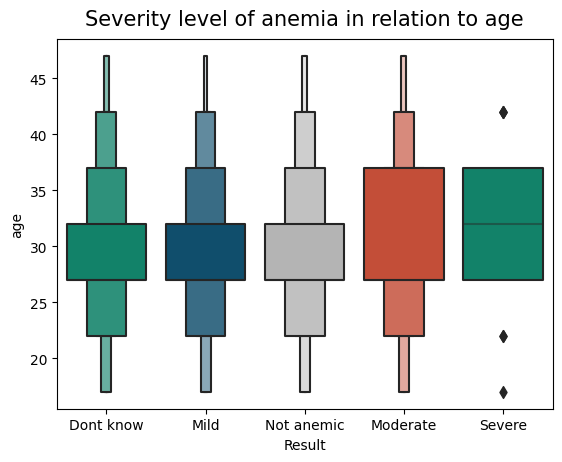

In [49]:
# Create a boxenplot to visualize the relationship between the severity levels of anemia and age

plt.figure()
pl = sns.boxenplot(x=dot_df_copy['Result'], y=dot_df_copy['age'], palette=pal)
pl.set_title("Severity level of anemia in relation to age", pad=10, size=15)
plt.show()


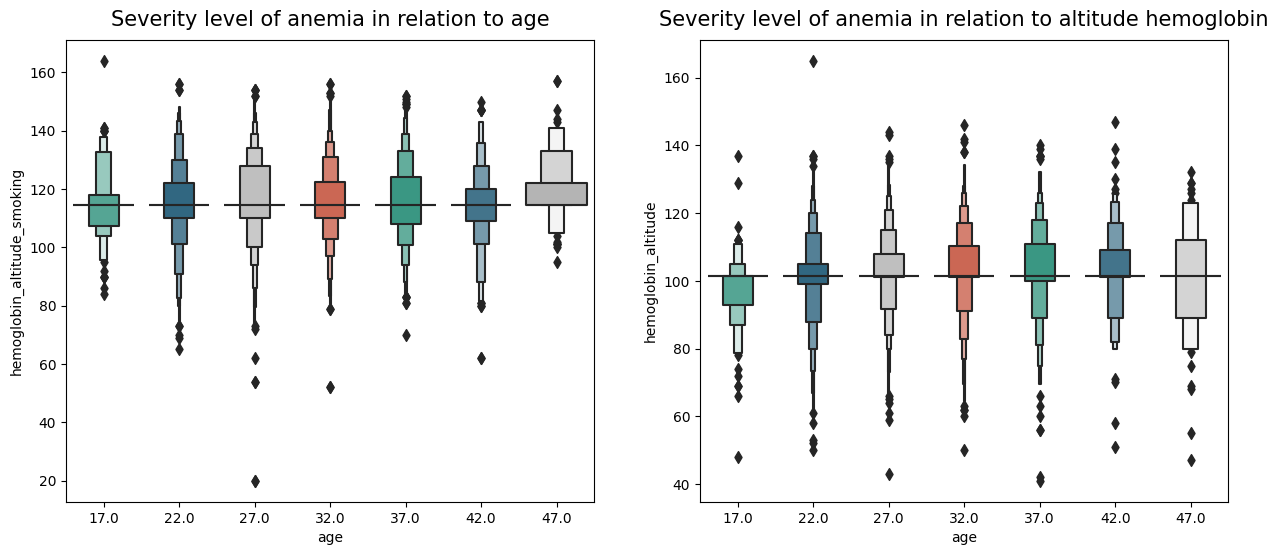

In [50]:

# Create a grid with two subplots on the horizontal axis
# The visualization of data for a smoker and a non-smoker based on age

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Boxenplot for the first column
sns.boxenplot(x=dot_df_copy['age'], y=dot_df_copy['hemoglobin_altitude_smoking'], palette=pal, ax=axs[0])
axs[0].set_title("Severity level of anemia in relation to age", pad=10, size=15)

# Boxenplot for the second column
sns.boxenplot(x=dot_df_copy['age'], y=dot_df_copy['hemoglobin_altitude'], palette=pal, ax=axs[1])
axs[1].set_title("Severity level of anemia in relation to altitude hemoglobin", pad=10, size=15)

# Display the subplots
plt.show()


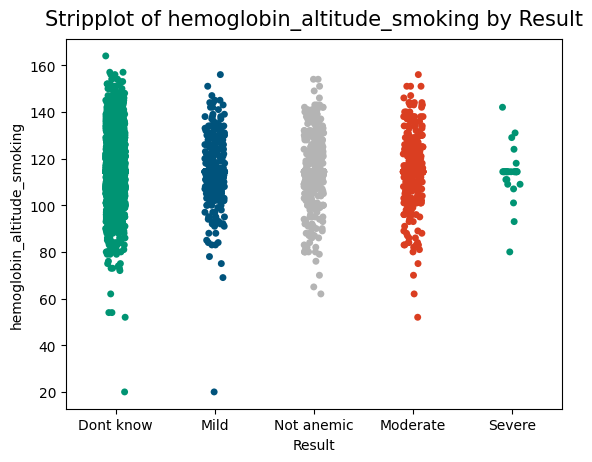

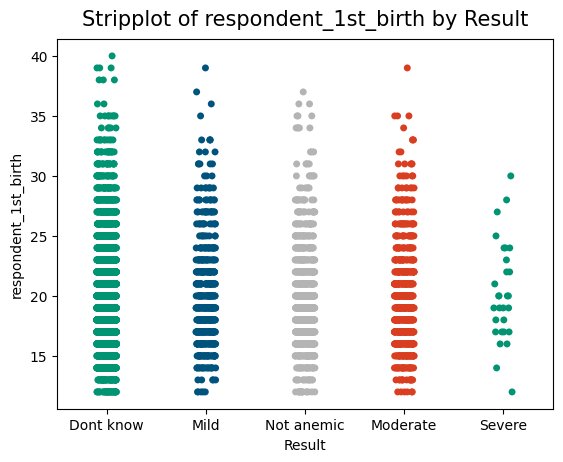

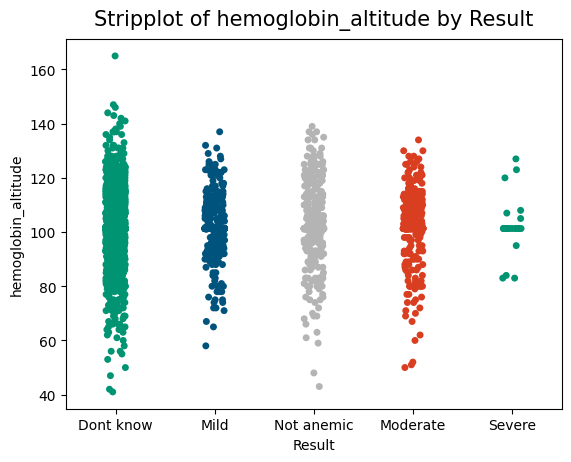

In [51]:
# Create strip plots to visualize the relationship between different columns and the severity levels of anemia

columns = ['hemoglobin_altitude_smoking', 'respondent_1st_birth', 'hemoglobin_altitude']

for i in columns:
    plt.figure()
    sns.stripplot(x=dot_df_copy["Result"], y=dot_df_copy[i], palette=pal, jitter=True)
    plt.title(f'Stripplot of {i} by Result', pad=10, size=15)
    plt.show()


# A brief conclusion: 
* Altitude hemoglobin levels can provide significant insights into the overall health status of respondents. There is a clear association between smoking and hemoglobin levels, indicating an influence of this habit on hemoglobin.

* Age is a crucial factor in determining the risk of anemia. Analyses show that certain age groups, such as those between 27 and 37 years old, may have a higher risk of developing anemia. Detailed statistical analysis can highlight and quantify these relationships, providing a more nuanced perspective on the influence of age on health status and hemoglobin levels.